In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import math
import pprint
from sklearn import preprocessing
import re

In [91]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer, sent_tokenize
import nltk
nltk.download('punkt')
from nltk import word_tokenize

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mattcirelli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [92]:
# Update SIA with Loughran McDonald Dictionary

import csv
import pandas as pd

# stock market lexicon
stock_lex = pd.read_csv('stock_lex.csv')

stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

#update the positive and negative dictionaries
positive = []
reader = csv.reader('lm_positive.csv')
for row in reader:
    positive.append(row[0].strip())
    
negative = []
reader = csv.reader('lm_negative.csv')
for row in reader:
    entry = row[0].strip().split(" ")
    if len(entry) > 1:
        negative.extend(entry)
    else:
        negative.append(entry[0])

final_lex = {}
final_lex.update({word:2.0 for word in positive})
final_lex.update({word:-2.0 for word in negative})
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

In [120]:
data = pd.read_csv('apple_news.csv')

In [121]:
data.head()

,Unnamed: 0,company,id,publication_date,summary,title,url
0,0,NaN,nws_WOko10,2019-08-07 01:00:56+00:00,Fortnite is the most popular battle-royale gam...,"How Does Fortnite Make Money: Online Gaming, e...",https://finance.yahoo.com/m/415d0b04-cbf2-3434...
1,1,NaN,nws_DkpvDv,2019-08-06 23:43:11+00:00,Walmart (WMT) looks strong heading into the re...,Why Walmart (WMT) Stock Looks Like a Buy Ahead...,https://finance.yahoo.com/news/why-walmart-wmt...
2,2,NaN,nws_WOko7Y,2019-08-06 22:56:16+00:00,"(Bloomberg) -- Amazon.com Inc., Facebook Inc. ...","Amazon, Facebook, Google Defend Practices Amid...",https://finance.yahoo.com/news/amazon-defends-...
3,3,NaN,nws_jv3p4w,2019-08-06 22:12:00+00:00,"After much anticipation, Apple is finally rele...",Here’s everything Apple isn’t telling you abou...,https://finance.yahoo.com/m/38765c24-aaf5-3971...
4,4,NaN,nws_LJW57O,2019-08-06 21:49:00+00:00,The calling feature in the apps runs in the ba...,Apple to restrict Facebook's messaging apps fe...,https://finance.yahoo.com/news/apple-restrict-...


In [122]:
data['publication_date']=pd.to_datetime(data.publication_date,format='%Y-%m-%d')
data.index =data['publication_date']


In [123]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67550 entries, 2019-08-07 01:00:56 to 2016-05-24 00:17:38
Data columns (total 7 columns):
Unnamed: 0          67550 non-null int64
company             0 non-null float64
id                  67550 non-null object
publication_date    67550 non-null datetime64[ns]
summary             67534 non-null object
title               67550 non-null object
url                 67549 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 4.1+ MB


In [124]:
data.head()

,Unnamed: 0,company,id,publication_date,summary,title,url
publication_date,,,,,,,
2019-08-07 01:00:56,0,NaN,nws_WOko10,2019-08-07 01:00:56,Fortnite is the most popular battle-royale gam...,"How Does Fortnite Make Money: Online Gaming, e...",https://finance.yahoo.com/m/415d0b04-cbf2-3434...
2019-08-06 23:43:11,1,NaN,nws_DkpvDv,2019-08-06 23:43:11,Walmart (WMT) looks strong heading into the re...,Why Walmart (WMT) Stock Looks Like a Buy Ahead...,https://finance.yahoo.com/news/why-walmart-wmt...
2019-08-06 22:56:16,2,NaN,nws_WOko7Y,2019-08-06 22:56:16,"(Bloomberg) -- Amazon.com Inc., Facebook Inc. ...","Amazon, Facebook, Google Defend Practices Amid...",https://finance.yahoo.com/news/amazon-defends-...
2019-08-06 22:12:00,3,NaN,nws_jv3p4w,2019-08-06 22:12:00,"After much anticipation, Apple is finally rele...",Here’s everything Apple isn’t telling you abou...,https://finance.yahoo.com/m/38765c24-aaf5-3971...
2019-08-06 21:49:00,4,NaN,nws_LJW57O,2019-08-06 21:49:00,The calling feature in the apps runs in the ba...,Apple to restrict Facebook's messaging apps fe...,https://finance.yahoo.com/news/apple-restrict-...


In [125]:
str(data["summary"])

"publication_date\n2019-08-07 01:00:56    Fortnite is the most popular battle-royale gam...\n2019-08-06 23:43:11    Walmart (WMT) looks strong heading into the re...\n2019-08-06 22:56:16    (Bloomberg) -- Amazon.com Inc., Facebook Inc. ...\n2019-08-06 22:12:00    After much anticipation, Apple is finally rele...\n2019-08-06 21:49:00    The calling feature in the apps runs in the ba...\n2019-08-06 20:56:00    Apple Inc.  subsidiary FileMaker Inc. has a ne...\n2019-08-06 20:34:10    The stock market today rebounded after sufferi...\n2019-08-06 20:24:00    The stock market has been volatile, causing co...\n2019-08-06 20:23:30    Guru's largest sales of the 2nd quarter Contin...\n2019-08-06 20:16:00    The Apple credit card designed primarily for m...\n2019-08-06 20:13:32    Remembering the old adage about stocks falling...\n2019-08-06 18:23:06    On today's episode of Free Lunch here at Zacks...\n2019-08-06 18:14:02    Every time the stock market dips -- even sligh...\n2019-08-06 18:04:44

In [126]:
#drop any duplicated headlines
data = data.sort_values(['summary']).drop_duplicates(subset='title')
data = data.sort_values(['publication_date'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'publication_date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [127]:
# Concatenate all news into one
#data["summary"] = data.filter(regex=("Top.*")).apply(lambda x: ''.join(str(x.values)), axis=1)

In [128]:
#Tokenize Words Data 
text=data["summary"][1]
from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(text)
print(tokenized_word)

['More', 'challenges', 'than', 'cheer', 'for', 'Apple', 'chief', 'on', 'Asia', 'tour']


In [129]:
##Tokenize Sentences Data
from nltk.tokenize import sent_tokenize
tokenized_text=sent_tokenize(text)
print(tokenized_text)

['More challenges than cheer for Apple chief on Asia tour']


In [130]:
#Import English Stopwords
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'having', 'further', 'there', "that'll", 'too', 'until', 'm', 'after', 'because', 'they', 'more', 'won', "hadn't", 'same', "didn't", "isn't", 'wouldn', 'can', "haven't", 'how', 'once', 'are', 'which', "mightn't", 'couldn', 'both', 'through', 'doesn', "needn't", 'from', "it's", 'mightn', 'you', "wouldn't", 'theirs', 'during', "shan't", 'before', 'who', 'them', 'aren', 'each', 'myself', 'we', 'were', 'only', "hasn't", 'she', 'while', 'needn', 'shan', "doesn't", 'had', 'ours', "you'd", 'have', 'just', 'your', 'up', 'weren', 'any', 'hasn', 'where', 'is', 'didn', 'was', 'ma', 'do', 'ourselves', "you've", 'its', 'll', 'haven', 'being', 'i', 'doing', "you'll", 'a', 'am', 'under', 'shouldn', 'wasn', 'my', "weren't", 'into', 'if', 'it', "she's", 'itself', 'few', "mustn't", "wasn't", 'on', 'those', 'than', 'as', 'nor', 'his', 'yours', 'themselves', 'out', 'some', 'be', 're', 'the', 'about', 'and', 'should', 'hadn', 'between', 'below', 'then', "won't", 'hers', 'what', 'himself', 'isn', 'an', "ar

In [131]:
#Filter Stopwords
filtered_sent=[]
for w in tokenized_text:
    if w not in stop_words:
        filtered_sent.append(w)
print("Tokenized Sentence:",tokenized_text)
print("Filterd Sentence:",filtered_sent)

Tokenized Sentence: ['More challenges than cheer for Apple chief on Asia tour']
Filterd Sentence: ['More challenges than cheer for Apple chief on Asia tour']


https://github.com/Currie32/Predicting-the-Dow-Jones-with-Headlines/blob/master/Predict_Dow_with_News.ipynb
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

# Clean the headlines
clean_headlines = []

for daily_headlines in data["summary"]:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [138]:
str(data["title"])

"publication_date\n2016-05-24 00:17:38    Wall Street dips; Apple gain fails to offset r...\n2016-05-24 08:42:12    More challenges than cheer for Apple chief on ...\n2016-05-25 17:48:27    India says Apple must sell locally-sourced goo...\n2016-05-30 17:05:39    India discussing Apple's request for FDI rules...\n2016-06-01 08:29:12    Apple plans to sell $1 bln of 30-yr bonds in T...\n2016-06-02 20:16:42     S&P 500 closes at seven-month high on data boost\n2016-06-20 12:40:46    India opens the door for Apple retail with new...\n2016-06-22 03:12:40    Samsung takes fight to Apple with mobile walle...\n2016-06-23 10:22:07    High-end smartphone market set to grow in Indi...\n2016-07-15 06:58:29    S&P 500's record highs held back by Apple's fa...\n2016-07-18 18:18:18    Japan's Son chased $32 billion ARM deal by the...\n2016-07-21 18:04:52            Pokemon Go seen making billions for Apple\n2016-07-22 19:41:54    Silicon Valley leads avalanche of quarterly re...\n2016-07-26 10:53:54

In [134]:
print(data["summary"])

publication_date
2016-05-24 00:17:38    Wall Street dips; Apple gain fails to offset r...
2016-05-24 08:42:12    More challenges than cheer for Apple chief on ...
2016-05-25 17:48:27    India says Apple must sell locally-sourced goo...
2016-05-30 17:05:39    India discussing Apple's request for FDI rules...
2016-06-01 08:29:12    Apple plans to sell $1 bln of 30-yr bonds in T...
2016-06-02 20:16:42     S&P 500 closes at seven-month high on data boost
2016-06-20 12:40:46    India opens the door for Apple retail with new...
2016-06-22 03:12:40    Samsung takes fight to Apple with mobile walle...
2016-06-23 10:22:07    High-end smartphone market set to grow in Indi...
2016-07-15 06:58:29    S&P 500's record highs held back by Apple's fa...
2016-07-18 18:18:18    Japan's Son chased $32 billion ARM deal by the...
2016-07-21 18:04:52            Pokemon Go seen making billions for Apple
2016-07-22 19:41:54    Silicon Valley leads avalanche of quarterly re...
2016-07-26 10:53:54    [AFP] - App

### SIA compound score Calculation 
https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/


In [139]:
sia = SIA()
results = []

for line in data["title"]:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

print(results[:3])

[{'neg': 0.35, 'neu': 0.438, 'pos': 0.212, 'compound': -0.296, 'headline': 'Wall Street dips; Apple gain fails to offset rate worries'}, {'neg': 0.0, 'neu': 0.608, 'pos': 0.392, 'compound': 0.6318, 'headline': 'More challenges than cheer for Apple chief on Asia tour'}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'headline': 'India says Apple must sell locally-sourced goods to set up stores - source'}]


In [140]:
df123 = pd.DataFrame(results)
#df123['publication_date'] = data['publication_date']
#df123.Date = pd.to_datetime(df123.publication_date)
#df123.set_index('publication_date', inplace=True)
df123.head()

,compound,headline,neg,neu,pos
0,-0.2960,Wall Street dips; Apple gain fails to offset r...,0.35,0.438,0.212
1,0.6318,More challenges than cheer for Apple chief on ...,0.00,0.608,0.392
2,0.0000,India says Apple must sell locally-sourced goo...,0.00,1.000,0.000
3,0.0000,India discussing Apple's request for FDI rules...,0.00,1.000,0.000
4,0.0000,Apple plans to sell $1 bln of 30-yr bonds in T...,0.00,1.000,0.000


In [141]:
print(df123['headline'][1])

More challenges than cheer for Apple chief on Asia tour


In [142]:
df123.describe()

,compound,neg,neu,pos
count,54918.000000,54918.000000,54918.000000,54918.000000
mean,0.044534,0.063137,0.846626,0.090238
std,0.307948,0.119530,0.167945,0.135918
min,-0.922200,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.727000,0.000000
50%,0.000000,0.000000,0.864000,0.000000
75%,0.202300,0.098000,1.000000,0.189000
max,0.913600,0.770000,1.000000,0.857000


In [143]:
df123.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54918 entries, 0 to 54917
Data columns (total 5 columns):
compound    54918 non-null float64
headline    54918 non-null object
neg         54918 non-null float64
neu         54918 non-null float64
pos         54918 non-null float64
dtypes: float64(4), object(1)
memory usage: 2.1+ MB


In [144]:
df123['label'] = 0
df123.loc[df123['compound'] > 0.1, 'label'] = 1
df123.loc[df123['compound'] < -0.1, 'label'] = -1
df123.head()

,compound,headline,neg,neu,pos,label
0,-0.2960,Wall Street dips; Apple gain fails to offset r...,0.35,0.438,0.212,-1
1,0.6318,More challenges than cheer for Apple chief on ...,0.00,0.608,0.392,1
2,0.0000,India says Apple must sell locally-sourced goo...,0.00,1.000,0.000,0
3,0.0000,India discussing Apple's request for FDI rules...,0.00,1.000,0.000,0
4,0.0000,Apple plans to sell $1 bln of 30-yr bonds in T...,0.00,1.000,0.000,0


In [145]:
print("Positive headlines:\n")
print(list(df123[df123['label'] == 1].headline)[:5])


Positive headlines:

['More challenges than cheer for Apple chief on Asia tour', 'S&P 500 closes at seven-month high on data boost', 'Apple quarterly profit slides 27 pct to $7.8 bn', 'Apple talks services amid drop in iPhone sales, profit', 'Apple sells more iPhones than expected, shares jump after hours']


In [146]:
print("\nNegative headlines:\n")
print(list(df123[df123['label'] == -1].headline)[:5])


Negative headlines:

['Wall Street dips; Apple gain fails to offset rate worries', 'Samsung takes fight to Apple with mobile wallet strategy', "S&P 500's record highs held back by Apple's falling stock price", "ANZ 'pulled fast one' on Apple Pay: rivals", "ANZ 'pulled fast one' on Apple Pay"]


In [147]:
print(df123.label.value_counts())

print(df123.label.value_counts(normalize=True) * 100)

 0    27267
 1    16535
-1    11116
Name: label, dtype: int64
 0    49.650388
 1    30.108525
-1    20.241087
Name: label, dtype: float64


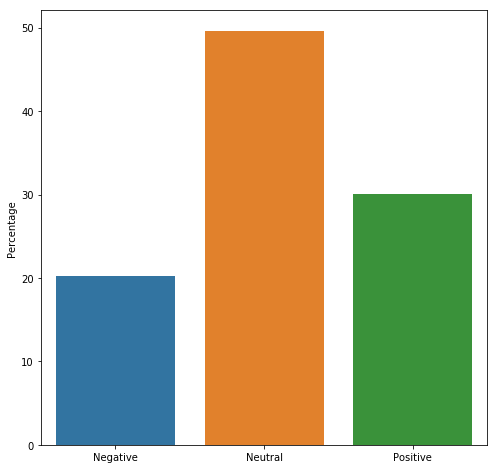

In [148]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 8))

counts = df123.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Count')

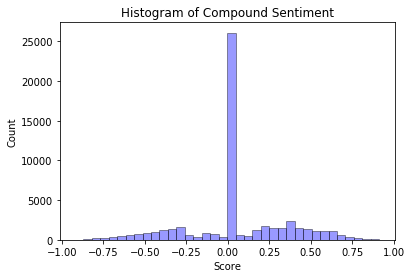

In [149]:

# seaborn histogram
sns.distplot(df123['compound'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Compound Sentiment')
plt.xlabel('Score')
plt.ylabel('Count')

In [150]:
#https://github.com/llSourcell/Stock_Market_Prediction/blob/master/Generating%20Different%20Models.ipynb
#import numpy as np
#import pandas as pd
#from nltk.classify import NaiveBayesClassifier
#from nltk.corpus import subjectivity
#from nltk.sentiment import SentimentAnalyzer
#from nltk.sentiment.util import *
#import nltk
#nltk.downloader.download('vader_lexicon')

#sentence = 'paris shootout police officer suspected guman dead'
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
#import unicodedata
#sid = SentimentIntensityAnalyzer()
#ss = sid.polarity_scores(sentence)
#ss

In [151]:
df123.index =data['publication_date']
df123.head()

,compound,headline,neg,neu,pos,label
publication_date,,,,,,
2016-05-24 00:17:38,-0.2960,Wall Street dips; Apple gain fails to offset r...,0.35,0.438,0.212,-1
2016-05-24 08:42:12,0.6318,More challenges than cheer for Apple chief on ...,0.00,0.608,0.392,1
2016-05-25 17:48:27,0.0000,India says Apple must sell locally-sourced goo...,0.00,1.000,0.000,0
2016-05-30 17:05:39,0.0000,India discussing Apple's request for FDI rules...,0.00,1.000,0.000,0
2016-06-01 08:29:12,0.0000,Apple plans to sell $1 bln of 30-yr bonds in T...,0.00,1.000,0.000,0


In [152]:
df123.to_csv('AAPL_sent_news.csv')